In [1]:
from Helpers.bvp import BVP
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from scipy.integrate import solve_ivp
from math import ceil

<!-- Set size to small -->
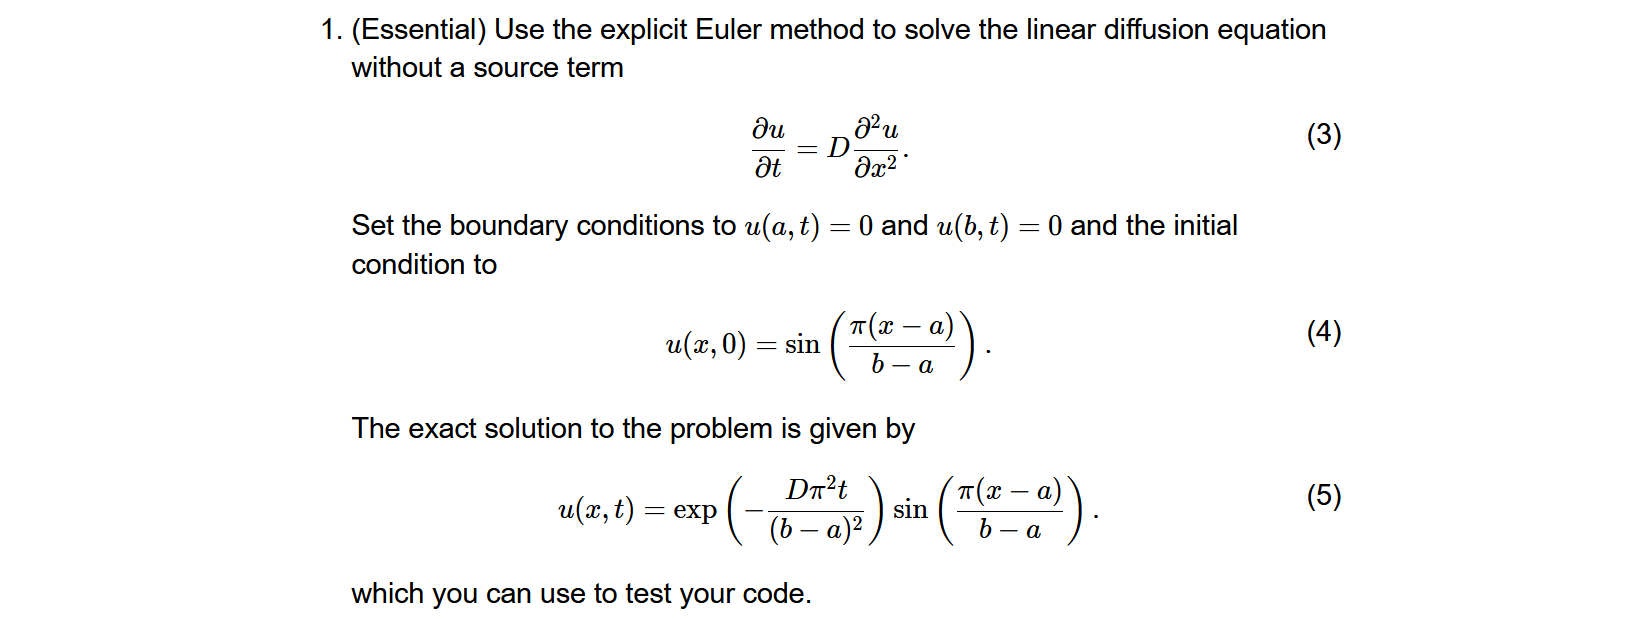

In [106]:
# Problem 1: u' = D*u''
a = 0
b = 1
alpha = 0
beta = 0
f_fun = lambda x, t: np.sin(np.pi * (x - a) / (b - a))
D = 0.1
N = 100

analytic_sol = lambda x, t: np.exp(-D * np.pi**2 * t / (b-a)**2) * np.sin(np.pi * (x - a) / (b - a))

bvp = BVP(a, b, N, alpha, beta, condition_type='Dirichlet', f_fun=f_fun, D=D)

t_boundary = 0
dt = 0.0001
t_final = 1

t = bvp.time_discretization(dt, t_boundary, t_final)

# Explicit Euler method
C = D * dt / bvp.dx**2

# Rearrange the solution to be in the same format as the BVP solution
u = np.zeros((len(bvp.x_values), len(t)))
u[:, 0] = f_fun(bvp.x_values, t_boundary)
u[0, :] = alpha
u[-1, :] = beta

# Loop over time
for ti in range(0, len(t)-1):
    for xi in range(0, N):
        if xi == 0:
            # u[0, ti+1] = u[0, ti] + bvp.C * (alpha - 2 * u[0, ti] + u[1, ti])
            u[xi, ti+1] = alpha
        elif xi > 0 and xi < N:
            u[xi, ti+1] = u[xi, ti] + bvp.C * (u[xi-1, ti] - 2 * u[xi, ti] + u[xi+1, ti])
        else:
            u[xi, ti+1] = u[xi, ti] + bvp.C * (beta - 2 * u[xi, ti] + u[xi-1, ti])

In [107]:
# Check against fixed t
idx = [1000, 2000, 3000]
t_checks = t[idx]
print(t_checks)

fig = go.Figure()
for t_check in t_checks:
    idx = np.where(t == t_check)[0][0]
    fig.add_trace(go.Scatter(x=bvp.x_values, y=u[:, idx], name=f't = {t_check}'))
    fig.add_trace(go.Scatter(x=bvp.x_values, y=analytic_sol(bvp.x_values, t_check), name=f'Analytic t = {t_check}', mode='lines', line=dict(dash='dash')))

fig.show()

[0.1 0.2 0.3]


In [110]:
bvp.dx

0.01

In [125]:
a = 0
b = 1
alpha = 0
beta = 0
f_fun = lambda x, t: np.sin(np.pi * (x - a) / (b - a))
D = 0.1
N = 500

analytic_sol = lambda x, t: np.exp(-D * np.pi**2 * t / (b-a)**2) * np.sin(np.pi * (x - a) / (b - a))

bvp = BVP(a, b, N, alpha, beta, condition_type='Dirichlet', f_fun=f_fun, D=D)

C = 0.5
dt = C * bvp.dx**2 / D

t_boundary = 0
# dt = 0.0001
t_final = 1
t = bvp.time_discretization(dt, t_boundary, t_final)

# 4th order Runge-Kutta method
C = D * dt / bvp.dx**2

# Rearrange the solution to be in the same format as the BVP solution
u = np.zeros((len(bvp.x_values), len(t)))
u[:, 0] = f_fun(bvp.x_values, t_boundary)

# Loop over time
for ti in range(0, len(t)-1):
    print(f'Calculating time step {ti+1} of {len(t)-1}, {ceil((ti+1)/(len(t)-1)*100)}% complete', end='\r')
    for xi in range(0, N):
        if xi == 0:
            # k1 = bvp.C * (alpha -ti] + (k1 + 2*k2 + 2*k3 + k4) / 6
            u[xi, ti+1] = alpha
        elif xi > 0 and xi < N:
            k1 = bvp.C * (u[xi-1, ti] - 2 * u[xi, ti] + u[xi+1, ti])
            k2 = bvp.C * (u[xi-1, ti] - 2 * (u[xi, ti] + k1/2) + u[xi+1, ti])
            k3 = bvp.C * (u[xi-1, ti] - 2 * (u[xi, ti] + k2/2) + u[xi+1, ti])
            k4 = bvp.C * (u[xi-1, ti] - 2 * (u[xi, ti] + k3) + u[xi+1, ti])
            u[xi, ti+1] = u[xi, ti] + (k1 + 2*k2 + 2*k3 + k4) / 6
        else:
            k1 = bvp.C * (beta - 2 * u[xi, ti] + u[xi-1, ti])
            k2 = bvp.C * (beta - 2 * (u[xi, ti] + k1/2) + u[xi-1, ti])
            k3 = bvp.C * (beta - 2 * (u[xi, ti] + k2/2) + u[xi-1, ti])
            k4 = bvp.C * (beta - 2 * (u[xi, ti] + k3) + u[xi-1, ti])
            u[xi, ti+1] = u[xi, ti] + (k1 + 2*k2 + 2*k3 + k4) / 6

In [135]:
# Check against fixed t
idx = [10000, 20000, 30000]

fig = go.Figure()
for id in idx:
    t_check = t[id]
    print(t_check)
    # idx = np.where(t == t_check)[0][0]
    fig.add_trace(go.Scatter(x=bvp.x_values, y=u[:, id], name=f't = {t_check}'))
    fig.add_trace(go.Scatter(x=bvp.x_values, y=analytic_sol(bvp.x_values, t_check), name=f'Analytic t = {t_check}', mode='lines', line=dict(dash='dash')))
fig.show()


0.19999999999999998
0.39999999999999997
0.6


In [31]:
from scipy.integrate import solve_ivp
def solve_PDE(self, t, t_boundary):
    # t = self.time_discretization(dt, t_boundary, t_final)
    A, b, x_array = self.boundary_conditions()
    
    u_boundary = self.f_fun(x_array, t_boundary)  
    
    if self.q_fun is None:
        def PDE(t, u, D, A, b):
            return D / self.dx ** 2 * (A @ u + b)
    else:
        # q_fun(x, u)
        def PDE(t, u, D, A, b):
            return D / self.dx ** 2 * (A @ u + b) + self.q_fun(x_array, u)
        
    
    sol = solve_ivp(PDE, (t[0], t[-1]), u_boundary, method='RK45', t_eval=t, args=(self.D_const, A, b))

    y = sol.y
    t = sol.t

    solution = self.concatanate(y, type='PDE', t=t)
    return solution, t

In [32]:
# Bratu problem

a = 0
b = 1
N = 20
alpha = 0
beta = 0
D = 1
mu = 2

def q(x, u):
    return np.exp(mu*u)

def f(x, t):
    return np.zeros(len(x))

bvp = BVP(a, b, N, alpha, beta, condition_type='Dirichlet', q_fun=q, f_fun=f, D=D)

t_boundary = 0
t_final = 1
dt = 0.001
t = bvp.time_discretization(dt, t_boundary, t_final)

u, t = solve_PDE(bvp, t, t_boundary)

In [33]:
# 

from Helpers.bvp import BVP
import numpy as np
a = 0
b = 1
alpha = 0
beta = 0
f_fun = lambda x, t: np.sin(np.pi * (x - a) / (b - a))
D = 0.1
N = 100

analytic_sol = lambda x, t: np.exp(-D * np.pi**2 * t / (b-a)**2) * np.sin(np.pi * (x - a) / (b - a))

bvp = BVP(a, b, N, alpha, beta, condition_type='Dirichlet', f_fun=f_fun, D=D)

C = 0.4
dt = C * bvp.dx**2 / D

t_boundary = 0
# dt = 0.0001
t_final = 1
t = bvp.time_discretization(dt, t_boundary, t_final)
u, t = solve_PDE(bvp, t, t_boundary)

In [34]:
import plotly.graph_objects as go
# Check against fixed t
idx = [1000, 2000, 500]

fig = go.Figure()
for id in idx:
    t_check = t[id]
    print(t_check)
    # idx = np.where(t == t_check)[0][0]
    fig.add_trace(go.Scatter(x=bvp.x_values, y=u[:, id], name=f't = {t_check}'))
    fig.add_trace(go.Scatter(x=bvp.x_values, y=analytic_sol(bvp.x_values, t_check), name=f'Analytic t = {t_check}', mode='lines', line=dict(dash='dash')))
fig.show()

0.4
0.8
0.2
